In [2]:
!pip install transformers

     |████████████████████████████████| 1.1MB 6.6MB/s 
     |████████████████████████████████| 890kB 37.4MB/s 
     |████████████████████████████████| 3.0MB 51.2MB/s 
     |████████████████████████████████| 1.1MB 51.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=808f1a93f63ff7a4ed3ab371db94173ebd3fbb6390a120e985760de5a86f47c9
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel, pipeline
import torch
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sn

In [4]:
def load_model():
    tokenizer = AutoTokenizer.from_pretrained('youscan/ukr-roberta-base')
    model = AutoModel.from_pretrained('youscan/ukr-roberta-base')
    return tokenizer, model

In [18]:
def load_data(experiment=1):
    data = pd.read_csv('index.csv', index_col=0)
    if experiment == 2:
        x = pd.read_csv('index_aug_ua_en.csv', index_col=0)
        data = pd.concat([data, x]).reset_index(drop=True)
    elif experiment == 3:
        x = pd.read_csv('index_aug_ua_en_zh.csv', index_col=0)
        data = pd.concat([data, x]).reset_index(drop=True)

    data['description'] = data['description'].str.lower()
    data['description'] = data['description'].str.replace("’", "'")

    return data

In [19]:
def train_test_split(data):
    train_data = data[data['user'] <= 7].copy()
    test_data = data[data['user'] > 7].copy()
    return train_data, test_data

In [20]:
def model_embedding(text, tokenizer, model):
    input_ids = tokenizer(text, return_tensors="pt")["input_ids"]
    outputs = model(input_ids, output_hidden_states=True)
    emb = outputs[2]
    emb = np.array([i[0].detach().numpy() for i in emb])[:]
    emb = emb.mean(axis=(0, 1))
    return emb

In [21]:
tokenizer, model = load_model()
data = load_data(experiment=1)
train_data, test_data = train_test_split(data)

In [23]:
labels_list = train_data['word'].values
descriptions_list = train_data['description'].values
embeddings_list = {}

In [24]:
for l, d in zip(labels_list, descriptions_list):
    tmp = embeddings_list.get(l, [])
    tmp.append(model_embedding(d, tokenizer, model))
    embeddings_list[l] = tmp

In [25]:
for l, r in embeddings_list.items():
    embeddings_list[l] = np.mean(r, axis=0)

In [26]:
test_labels_list = test_data['word'].values
test_descriptions_list = test_data['description'].values

In [27]:
def distance(a, b):
  return sum([(i - j) ** 2 for i, j in zip(a, b)]) ** .5

In [29]:
t = 0
pred_labels = []
for ind in range(len(test_descriptions_list)):

    label = test_labels_list[ind]
    descr = test_descriptions_list[ind]
    print(f'LABEL {label}\tDESCR: {descr}')

    test_emb = model_embedding(descr, tokenizer, model)

    scores = list((distance(el, test_emb), k) for k, el in embeddings_list.items())
    sorted_scores = sorted(scores, key=lambda x: x[0])
    best_preds = sorted_scores[0][1]
    print(label, best_preds)
    pred_labels.append(best_preds)
    if label == best_preds:
        t += 1
print(t / len(test_descriptions_list))

LABEL кінь	DESCR: тварина, яку запрягають у віз, її силу прирівнюють до одиниць вимірювання міцності автомобілів.
кінь кінь
LABEL зебра	DESCR: тварина, яка має гриву, але не кінь.
зебра кінь
LABEL корова	DESCR: велика, рогата худоба.
корова олень
LABEL ведмідь	DESCR: впадає в сплячку взимку, любить мед.
ведмідь морквина
LABEL олень	DESCR: цим звіром нарікають людей, які чогось не розуміють.
олень пінгвін
LABEL страус	DESCR: птах, який ховає голову в пісок.
страус страус
LABEL курка	DESCR: домашня птиця, літає погано і недалеко.
курка курка
LABEL пінгвін	DESCR: птах, який живе на північному полюсі, темно синього кольору з білим животом.
пінгвін пінгвін
LABEL сова	DESCR: птах, полює на дрібних гризунів, переважно вночі.
сова сова
LABEL лебідь	DESCR: красивий, білий птах, переважно перебуває у воді.
лебідь сова
LABEL морквина	DESCR: овоч, який дуже полюбляють зайці, конусної форми.
морквина морквина
LABEL яблуко	DESCR: кислий, солодкий із кісточками всередині, корисно їсти зі шкіркою.
ябл

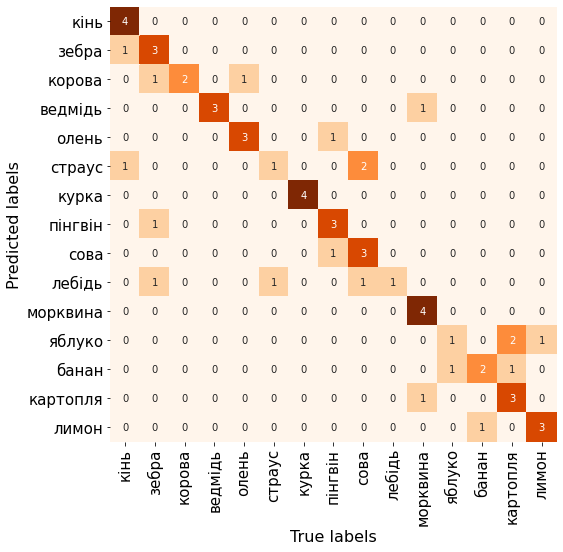

In [31]:
words = [
    'кінь', 'зебра', 'корова', 'ведмідь', 'олень', 
    'страус', 'курка', 'пінгвін', 'сова', 'лебідь', 
    'морквина', 'яблуко', 'банан', 'картопля', 'лимон'
]
m = metrics.confusion_matrix(test_labels_list, pred_labels, words)
df_cm = pd.DataFrame(m, index=words, columns=words)
plt.figure(figsize=(8, 8))
sn.heatmap(df_cm, annot=True, cbar=False, cmap='Oranges')
plt.xlabel('True labels', fontsize=16)
plt.xticks(fontsize=15)
plt.ylabel('Predicted labels', fontsize=16)
plt.yticks(fontsize=15);


In [32]:
mm = []
for i in range(3):
    mm.append([])
    for j in range(3):
        mm[-1].append(np.sum(m[5*i:5*(i+1), 5*j:5*(j+1)]))
mm

[[18, 1, 1], [3, 17, 0], [0, 0, 20]]

(array([0.5, 1.5, 2.5]), <a list of 3 Text major ticklabel objects>)

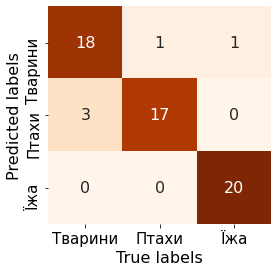

In [33]:
q = pd.DataFrame(mm, index=['Тварини', 'Птахи', 'Їжа'], columns=['Тварини', 'Птахи', 'Їжа'])
plt.figure(figsize=(4, 4))
sn.heatmap(q, annot=True, cbar=False, cmap='Oranges', annot_kws={"size": 16})
plt.xlabel('True labels', fontsize=16)
plt.xticks(fontsize=15)
plt.ylabel('Predicted labels', fontsize=16)
plt.yticks(fontsize=15)